# Train- Data Loading

In [4]:
# !pip install pytorch_lightning torchmetrics

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm


## Train and Validation Dataset

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
# /content/gdrive/MyDrive/Colab Notebooks/Dataset/Processed.zip

In [7]:
!unzip -q -o /content/gdrive/MyDrive/Colab\ Notebooks/Dataset/Processed.zip -d datasets


#### Loading npy files

In [8]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [9]:
train_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
])

In [10]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [11]:
train_dataset = torchvision.datasets.DatasetFolder("/content/datasets/train/", loader=load_file, extensions="npy", transform=train_transforms)

In [12]:
val_dataset = torchvision.datasets.DatasetFolder("/content/datasets/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [13]:
type(train_dataset)

torchvision.datasets.folder.DatasetFolder

### Display Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


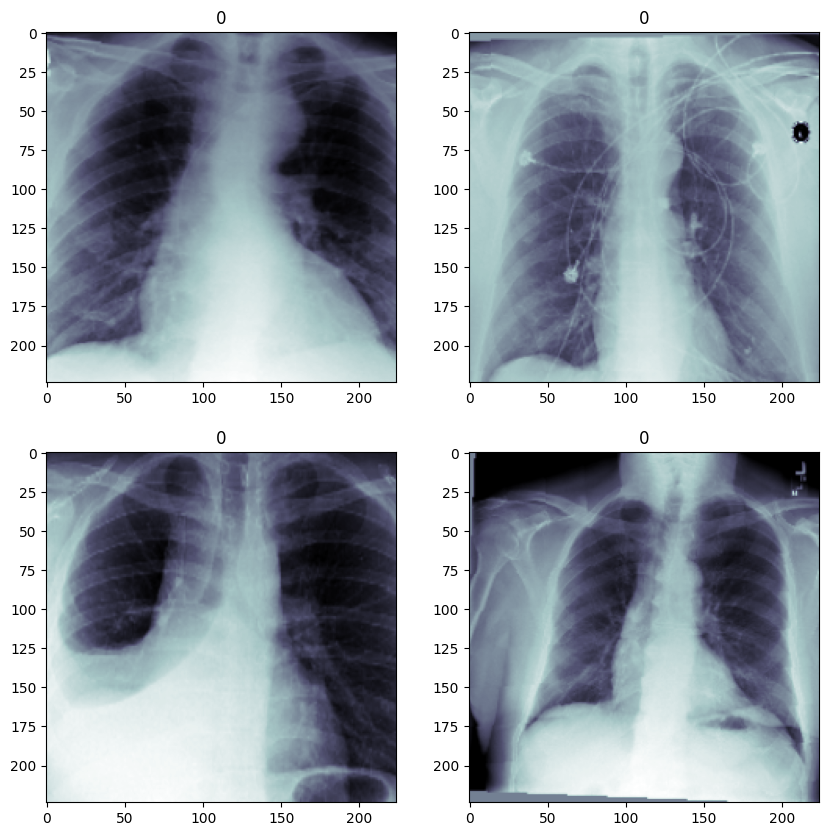

In [14]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

for row in range(2):
  for column in range(2):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]    # tuple unpacking
    axis[row][column].imshow(x_ray[0,:,:], cmap="bone")
    axis[row][column].set_title(label)


### Data Loader

In [15]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

# Define Lightning Model

In [17]:
# Change Input and Output shape

class PneumoniaModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.training_step_outputs = []
    self.validation_step_outputs = []
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

    self.train_acc = torchmetrics.Accuracy(task='binary')
    self.val_acc = torchmetrics.Accuracy(task='binary')


  def forward(self, X):
    pred = self.model(X)
    return pred


  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()         # shape of [batch_size]
    pred = self(x_ray)[:,0]       # convert to shape of [batch_size]
    loss = self.loss_fn(pred, label)
    self.training_step_outputs.append(loss)


    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

    return loss


  def on_train_epoch_end(self):
    self.log("Train ACC", self.train_acc.compute())

    epoch_average = torch.stack(self.training_step_outputs).mean()
    self.log("training_epoch_average", epoch_average)
    self.training_step_outputs.clear()  # free memory


  def validation_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()         # shape of [batch_size]
    pred = self(x_ray)[:,0]       # convert to shape of [batch_size]
    loss = self.loss_fn(pred, label)

    self.validation_step_outputs.append(loss)

    self.log("Val Loss", loss)
    self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))


  def on_validation_epoch_end(self):
    self.log("Val ACC", self.val_acc.compute())

    epoch_average = torch.stack(self.validation_step_outputs).mean()
    self.log("validation_epoch_average", epoch_average)
    self.validation_step_outputs.clear()  # free memory


  def configure_optimizers(self):
    return [self.optimizer]



## Train Model

In [18]:
model = PneumoniaModel()

In [19]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val ACC",
    save_top_k=1,
    mode="max"
)

In [20]:
trainer = pl.Trainer(
    logger=TensorBoardLogger(save_dir="/content/logs"),
    log_every_n_steps=4,
    callbacks=checkpoint_callback,
    max_epochs=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# @title Default title text
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
